# Librerias

In [51]:
import pandas as pd
import numpy as np
import re # expresiones regulares (regex)
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
from sklearn.preprocessing import MaxAbsScaler

# Preprocesamiento

* Eliminamos stopwords
* lematizamos
* Normalizamos el texto (quitamos mayúsculas y signos de puntuación)
* Vectorizamos y hacemos n-gramas
* Usamos SVD para ver cuantos topicos pueden tener los documentos

In [52]:
# Leer archivo .csv 
df = pd.read_csv('mañaneras.csv')

textoPrueba = df[['description']].copy() # Pongo .copy() porque cuando intentas 
                                  # quitar las stopwords sale un warning.
# textoPrueba = textoPrueba.head(1000)

print(textoPrueba.shape[0])
textoPrueba.head(10)

220


,description
0,Hoy conmemoramos la lucha de las mujeres por ...
1,Hoy dimos a conocer el análisis de la recient...
2,Hoy dimos a conocer que ya firmamos la carta ...
3,Hoy informamos sobre las acciones para mejora...
4,En el Gobierno de México avanzamos con entusi...
5,Informamos que hoy enviaremos al Senado de la...
6,Hoy informamos qué marcas y qué entidades fed...
7,Continuamos con las reuniones del Gabinete de...
8,"Como cada lunes, informamos las marcas y esta..."
9,Hoy refrendamos nuestro respeto a la libre ma...


Eliminamos stopwords

In [53]:
# Función para eliminar stopwords en español

def noStopwords(text):
    
    stopWord = stopwords.words('spanish')
    stopWord.extend(['mil', 'millón', 'millon', 'pregunta', 'respuesta'])
    sw_es = set(stopWord)

    text = ' '.join([word for word in text.split() if word.lower() not in sw_es])
    
    return text


In [54]:
textoPrueba['description'] = textoPrueba['description'].apply(noStopwords)
textoPrueba.head()

,description
0,Hoy conmemoramos lucha mujeres igualdad violen...
1,Hoy dimos conocer análisis reciente aprobación...
2,Hoy dimos conocer firmamos carta compromiso so...
3,Hoy informamos acciones mejorar Mecanismo prot...
4,Gobierno México avanzamos entusiasmo población...


Aplicamos lematización

In [89]:
# Función para lematizar al texto
def lemmatize_text(text):

    # Cargamos el módulo de español
    nlp = spacy.load("es_core_news_lg")

    # nlp crea una pipeline que le adhiere metadata que la paquetería spacy usa
    doc = nlp(text)

    lemmatized_text = " ".join([token.lemma_ for token in doc])
    
    return lemmatized_text

In [90]:
textoPrueba['description'] = textoPrueba['description'].apply(lemmatize_text)
textoPrueba.head()

,description,Main Topic,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,hoy conmemorar lucha mujer igualdad violencio ...,8,0.107769,0.096090,0.141628,0.005915,0.094676,0.138897,0.055252,0.065709,0.167153,0.126910
1,hoy dar conocer analisis reciente aprobacion t...,1,0.000026,0.999763,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026
2,hoy dar conocer firmamo carta compromiso somet...,0,0.999775,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025
3,hoy informar accion mejorar mecanismo protecci...,4,0.000020,0.000020,0.000020,0.000020,0.999824,0.000020,0.000020,0.000020,0.000020,0.000020
4,gobierno mexico avanzar entusiasmo poblacion r...,5,0.000023,0.000023,0.000023,0.000023,0.000023,0.999797,0.000023,0.000023,0.000023,0.000023


Aplicamos otra vez la eliminación de stopwords para quitar palabras que no soy stopwords pero aparecen mucho en los documentos sin dar información importante.

In [91]:
textoPrueba['description'] = textoPrueba['description'].apply(noStopwords)
textoPrueba.head()

,description,Main Topic,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,hoy conmemorar lucha mujer igualdad violencio ...,8,0.107769,0.096090,0.141628,0.005915,0.094676,0.138897,0.055252,0.065709,0.167153,0.126910
1,hoy dar conocer analisis reciente aprobacion t...,1,0.000026,0.999763,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026
2,hoy dar conocer firmamo carta compromiso somet...,0,0.999775,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025
3,hoy informar accion mejorar mecanismo protecci...,4,0.000020,0.000020,0.000020,0.000020,0.999824,0.000020,0.000020,0.000020,0.000020,0.000020
4,gobierno mexico avanzar entusiasmo poblacion r...,5,0.000023,0.000023,0.000023,0.000023,0.000023,0.999797,0.000023,0.000023,0.000023,0.000023


Normalizamos el texto, quitamos mayúsculas y signos de puntuación

In [92]:
# Función para normalizar el texto

def noPuntuacion(text):

    text = text.lower()

    text = re.sub('[áäàâ]', 'a', text)
    text = re.sub('[éëèê]', 'e', text)
    text = re.sub('[íïìî]', 'i', text)
    text = re.sub('[óöòô]', 'o', text)
    text = re.sub('[úüùû]', 'u', text)

    return re.findall(r'[a-zñ]+', text)

In [93]:
textoPrueba['description'] = textoPrueba['description'].apply(noPuntuacion).apply(lambda x: " ".join(x))
textoPrueba.head()

,description,Main Topic,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,hoy conmemorar lucha mujer igualdad violencio ...,8,0.107769,0.096090,0.141628,0.005915,0.094676,0.138897,0.055252,0.065709,0.167153,0.126910
1,hoy dar conocer analisis reciente aprobacion t...,1,0.000026,0.999763,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026
2,hoy dar conocer firmamo carta compromiso somet...,0,0.999775,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025
3,hoy informar accion mejorar mecanismo protecci...,4,0.000020,0.000020,0.000020,0.000020,0.999824,0.000020,0.000020,0.000020,0.000020,0.000020
4,gobierno mexico avanzar entusiasmo poblacion r...,5,0.000023,0.000023,0.000023,0.000023,0.000023,0.999797,0.000023,0.000023,0.000023,0.000023


Aplicamos stemming (Optamos por no ponerlo)

In [94]:
# # Función para aplicar stemming al texto

# def stemmiar(text):

#     stemmer = SnowballStemmer('spanish')

#     return ' '.join([stemmer.stem(word) for word in text.split()])

In [95]:
# textoPrueba['text'] = textoPrueba['text'].apply(stemmiar)
# textoPrueba.head()

Vectorizamos y hacemos n-gramas

In [96]:
# Creamos una instancia que hará la vectorización TF-IDF
vect = TfidfVectorizer()

# Tokenizamos como Penn Treebank
tokenizer = TreebankWordTokenizer()
vect.set_params(tokenizer=tokenizer.tokenize)

# Incluimos 1-grams y 2-grams
vect.set_params(ngram_range=(1, 3))

# Ignoramos términos que aparecen en más del 70% de los documentos
vect.set_params(max_df=0.7) 

# Solo mantenemos los términos que aparecen en al menos 2 documentos
vect.set_params(min_df=2) 

TfidfVectorizer(max_df=0.7, min_df=2, ngram_range=(1, 3),
                tokenizer=<bound method TreebankWordTokenizer.tokenize of <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x000002038FB9F4F0>>)

In [97]:
# Lo aplicamos
vectFit = vect.fit_transform(textoPrueba['description']) 
vectFit 

c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<220x33931 sparse matrix of type '<class 'numpy.float64'>'
	with 214260 stored elements in Compressed Sparse Row format>

In [98]:
print(vectFit[1])

  (0, 21493)	0.0416029236047554
  (0, 6204)	0.04399093830701692
  (0, 31089)	0.0416029236047554
  (0, 6578)	0.04399093830701692
  (0, 8229)	0.03823720591798975
  (0, 10332)	0.04399093830701692
  (0, 21265)	0.04399093830701692
  (0, 24438)	0.04399093830701692
  (0, 30876)	0.04399093830701692
  (0, 6402)	0.0832058472095108
  (0, 27924)	0.02911775584219695
  (0, 23526)	0.03695761944027206
  (0, 21379)	0.04399093830701692
  (0, 33510)	0.0416029236047554
  (0, 8943)	0.0416029236047554
  (0, 8547)	0.03823720591798975
  (0, 19736)	0.0416029236047554
  (0, 32526)	0.04399093830701692
  (0, 10978)	0.04399093830701692
  (0, 27352)	0.029592221044162648
  (0, 6793)	0.03487148823122411
  (0, 1597)	0.04399093830701692
  (0, 14474)	0.0416029236047554
  (0, 17734)	0.0416029236047554
  (0, 1968)	0.04399093830701692
  :	:
  (0, 6173)	0.01603941571007299
  (0, 19343)	0.040109964766169605
  (0, 5568)	0.02097600875090826
  (0, 8604)	0.046726675993257256
  (0, 17785)	0.016945866058078803
  (0, 23135)	0.01772

Descomposicion por valores singulares (SVD)

Hacemos z-score normalizacion

In [99]:
# Creamos la instancia 
scaler = StandardScaler(with_mean=False)
# Calculamos el promedio y la desviacion estandar
scaler.fit(vectFit)
# Re escalamos
vectFitScaled = scaler.transform(vectFit)

print(vectFitScaled[0])

  (0, 18895)	0.5880719326579116
  (0, 24770)	0.5880719326579116
  (0, 25199)	2.3897882769146133
  (0, 21974)	2.3897882769146133
  (0, 24992)	2.742851230296469
  (0, 24771)	4.700573282811599
  (0, 28852)	3.841512859043573
  (0, 18905)	7.310641339937714
  (0, 5448)	3.3441719988739758
  (0, 14189)	4.045738333422064
  (0, 7362)	3.7139594245944503
  (0, 32057)	1.2033773701701225
  (0, 19121)	2.440380756549539
  (0, 28498)	1.9304078131348985
  (0, 14246)	2.0937255559187014
  (0, 14596)	3.1896793046461314
  (0, 24276)	3.1896793046461314
  (0, 25313)	4.630040436050902
  (0, 2329)	4.630040436050902
  (0, 13637)	5.005997937582184
  (0, 24272)	5.005997937582184
  (0, 21104)	5.005997937582184
  (0, 17287)	2.9518108696445307
  (0, 26246)	1.7031493101937687
  (0, 10444)	1.9175246963681891
  :	:
  (0, 11065)	2.5357236668381464
  (0, 3897)	1.9492991356446037
  (0, 24178)	1.5619800173998792
  (0, 22885)	1.5383059859419757
  (0, 14984)	0.596705084394797
  (0, 19099)	1.8222509049035283
  (0, 17998)	1.620

In [100]:
# vectFitScaled = vectFitScaled.transpose()
# vectFitScaled

Aplicamos TruncatedSVD

In [101]:
# Creamos instancia de la clase TruncatedSVD
dimReduction = TruncatedSVD(n_components = textoPrueba.shape[0], random_state = 2)

In [102]:
# Ajustamos la transfromacion con nuestros datos
dimReduction.fit(vectFitScaled)

TruncatedSVD(n_components=220, random_state=2)

In [103]:
# Reducimos la dimensionalidad
dataReduction = dimReduction.transform(vectFitScaled)

Calculamos la variancia explicada

In [104]:
print("Variancia explicada por los 36,755 componentes = " \
        + str(sum(dimReduction.explained_variance_ratio_ * 100)))

Variancia explicada por los 36,755 componentes = 100.00000000000006


In [105]:
dimReduction.explained_variance_ratio_ * 100

array([1.38612254e-01, 1.11463279e+00, 8.83696991e-01, 7.50019670e-01,
       7.30353576e-01, 6.94207274e-01, 6.65118267e-01, 6.56475323e-01,
       6.48043449e-01, 6.45502274e-01, 6.31495082e-01, 6.30929969e-01,
       6.23080264e-01, 6.17425063e-01, 6.13578078e-01, 6.08673795e-01,
       6.06661159e-01, 6.05444842e-01, 5.96807389e-01, 5.93932993e-01,
       5.90333930e-01, 5.86793997e-01, 5.84217505e-01, 5.82012764e-01,
       5.79879108e-01, 5.77236238e-01, 5.75364280e-01, 5.72738720e-01,
       5.68755758e-01, 5.64842908e-01, 5.63067041e-01, 5.60920135e-01,
       5.59700975e-01, 5.58414159e-01, 5.55225072e-01, 5.53280659e-01,
       5.51123012e-01, 5.49159647e-01, 5.44478281e-01, 5.44271745e-01,
       5.43296287e-01, 5.41854840e-01, 5.40347946e-01, 5.37995594e-01,
       5.33605280e-01, 5.32050290e-01, 5.30118505e-01, 5.28919782e-01,
       5.27139069e-01, 5.25588882e-01, 5.24563918e-01, 5.22360120e-01,
       5.20350754e-01, 5.18895392e-01, 5.17958717e-01, 5.17742670e-01,
      

In [106]:
np.cumsum(dimReduction.explained_variance_ratio_ * 100)

array([  0.13861225,   1.25324505,   2.13694204,   2.88696171,
         3.61731528,   4.31152256,   4.97664083,   5.63311615,
         6.2811596 ,   6.92666187,   7.55815695,   8.18908692,
         8.81216719,   9.42959225,  10.04317033,  10.65184412,
        11.25850528,  11.86395012,  12.46075751,  13.0546905 ,
        13.64502444,  14.23181843,  14.81603594,  15.3980487 ,
        15.97792781,  16.55516405,  17.13052833,  17.70326705,
        18.27202281,  18.83686571,  19.39993275,  19.96085289,
        20.52055386,  21.07896802,  21.6341931 ,  22.18747375,
        22.73859677,  23.28775641,  23.83223469,  24.37650644,
        24.91980273,  25.46165757,  26.00200551,  26.54000111,
        27.07360639,  27.60565668,  28.13577518,  28.66469496,
        29.19183403,  29.71742291,  30.24198683,  30.76434695,
        31.2846977 ,  31.8035931 ,  32.32155181,  32.83929448,
        33.35578636,  33.87061507,  34.38303126,  34.89449245,
        35.40438711,  35.91340578,  36.41972376,  36.92

Text(0, 0.5, 'Variancia explicada (%)')

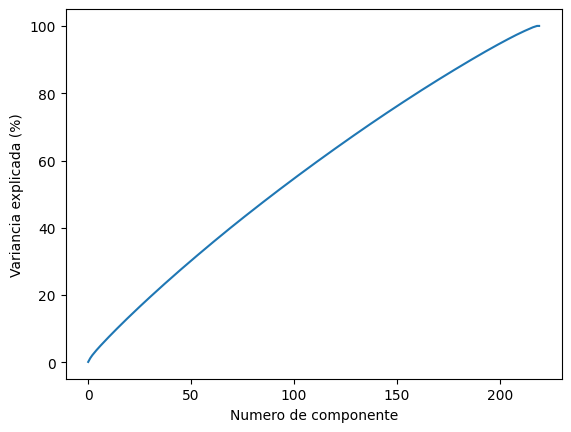

In [107]:
plt.plot(np.cumsum(dimReduction.explained_variance_ratio_ * 100))
plt.xlabel("Numero de componente")
plt.ylabel("Variancia explicada (%)")

Graficamos los componentes del TruncatedSVD con 2 componentes

In [108]:
# Creamos instancia de la clase TruncatedSVD
dimReduction2 = TruncatedSVD(n_components = 2, random_state = 2)

# Ajustamos la transfromacion con nuestros datos
dimReduction2.fit(vectFitScaled)

# Reducimos la dimensionalidad
dataReduction2 = dimReduction2.transform(vectFitScaled)

print("Variancia explicada por 2 componentes = " \
        + str(sum(dimReduction2.explained_variance_ratio_ * 100)))

Variancia explicada por 2 componentes = 1.2500194450782716


Text(0, 0.5, 'Segundo componente')

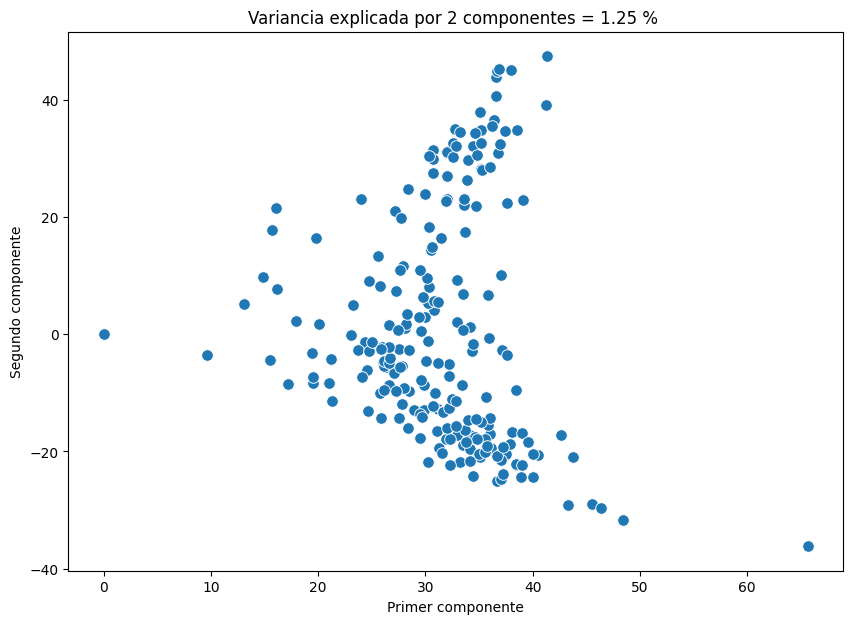

In [109]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=dataReduction2[:,0], y=dataReduction2[:,1], s=70)
plt.title(f"Variancia explicada por 2 componentes = {round(sum(dimReduction2.explained_variance_ratio_ * 100),3)} % ")
plt.xlabel("Primer componente")
plt.ylabel("Segundo componente")

In [110]:
# Creamos instancia de la clase TruncatedSVD
dimReduction3 = TruncatedSVD(n_components = 3, random_state = 2)

# Ajustamos la transfromacion con nuestros datos
dimReduction3.fit(vectFitScaled)

# Reducimos la dimensionalidad
dataReduction3 = dimReduction3.transform(vectFitScaled)

print("Variancia explicada por 3 componentes = " \
        + str(sum(dimReduction3.explained_variance_ratio_ * 100)))

Variancia explicada por 3 componentes = 2.1184049644837755


Text(0.5, 0, 'Tercer componente')

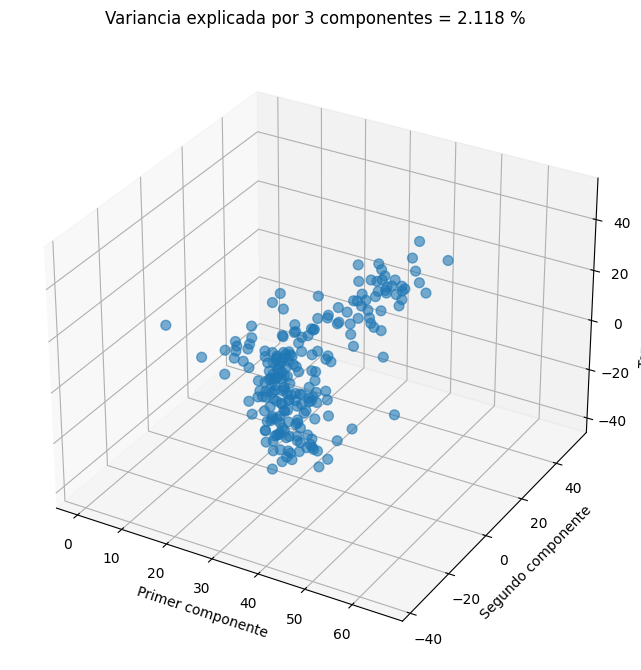

In [111]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
sctt = ax.scatter3D(dataReduction3[:,0], dataReduction3[:,1], dataReduction3[:,2], s=50, alpha = 0.6)
plt.title(f"Variancia explicada por 3 componentes = {round(sum(dimReduction3.explained_variance_ratio_ * 100),3)} % ", pad = 15)
ax.set_xlabel("Primer componente")
ax.set_ylabel("Segundo componente")
ax.set_zlabel("Tercer componente")

In [112]:
sumExpVariance = 0
for i in range(dimReduction.explained_variance_ratio_.shape[0]) :

    if (sumExpVariance > 0.95) :
        print(f"{i} componentes explican {round(sumExpVariance*100,3)} de la variancia")
        break

    sumExpVariance += dimReduction.explained_variance_ratio_[i]

202 componentes explican 95.123 de la variancia


Como podemos ver del análisis de componentes principales, no podemos sacar ninguna conclusión sobre la cantidad de tópicos del corpus. 

# Model LDA y su análisis

Gráfica wordCloud

c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\w

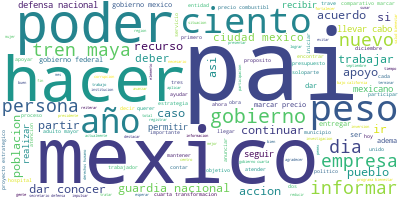

In [113]:
long_string = ','.join(list(textoPrueba['description'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

Estandarizamos la matriz para meterla al LDA

In [114]:
scaler = MaxAbsScaler()
scaler.fit(vectFit)
vectFitStandardized = scaler.transform(vectFit)

In [115]:
print(vectFitStandardized[1])

  (0, 21493)	0.9106752191745852
  (0, 6204)	1.0
  (0, 31089)	0.4890714745199386
  (0, 6578)	1.0
  (0, 8229)	1.0
  (0, 10332)	0.9934949038006858
  (0, 21265)	1.0
  (0, 24438)	1.0
  (0, 30876)	0.9781429490398771
  (0, 6402)	1.0
  (0, 27924)	0.6281704760148416
  (0, 23526)	0.2313940552847188
  (0, 21379)	1.0
  (0, 33510)	1.0
  (0, 8943)	1.0
  (0, 8547)	0.8203552390959171
  (0, 19736)	1.0
  (0, 32526)	1.0
  (0, 10978)	1.0
  (0, 27352)	0.6331387157489304
  (0, 6793)	0.9781429490398771
  (0, 1597)	1.0
  (0, 14474)	1.0
  (0, 17734)	1.0
  (0, 1968)	1.0
  :	:
  (0, 6173)	0.24419112749447483
  (0, 19343)	0.7506183359872628
  (0, 5568)	0.31523664395240725
  (0, 8604)	0.6880201723429706
  (0, 17785)	0.22101273765120705
  (0, 23135)	0.1358345311823746
  (0, 25435)	0.4864067648950799
  (0, 16897)	0.28745915680909584
  (0, 27321)	1.0
  (0, 7130)	0.34156659625327956
  (0, 13116)	0.27581606819625887
  (0, 29361)	0.13518581350887213
  (0, 18290)	0.6352736307196977
  (0, 26017)	0.40553656112108755
  (0, 

Obtención de palabras clave usando TF-IDF

In [116]:
# Obtener el vocabulario de términos
feature_names = vect.get_feature_names_out()

# Obtener las frecuencias de términos en el primer documento
doc_freqs = vectFit[0].toarray()[0]

# Crear una lista de tuplas que contienen el término y su frecuencia en el primer documento
doc_term_freqs = [(feature_names[i], doc_freqs[i]) for i in range(len(feature_names))]

# Ordenar la lista de tuplas por la frecuencia descendente
doc_term_freqs_sorted = sorted(doc_term_freqs, key=lambda x: x[1], reverse=True)

# Obtener las 10 palabras clave más importantes para el primer documento
doc_keywords = [term for term, freq in doc_term_freqs_sorted[:10]]

print(doc_keywords)


['combustible', 'ducto', 'robo combustible', 'plan robo combustible', 'audio', 'plan robo', 'pipa', 'robo', 'ir', 'tlahuelilpan']


### LDA intento 1

In [117]:
# Importar las bibliotecas necesarias
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pandas as pd
from nltk.tokenize import TreebankWordTokenizer

In [118]:
# Tokenizar los documentos utilizando el tokenizador de Penn Treebank
tokenizer = TreebankWordTokenizer()
documentos = []
for documento in textoPrueba['description'].tolist():
    tokens = tokenizer.tokenize(documento)
    documentos.append(tokens)

# Crear un diccionario de términos a partir de los documentos
dictionary = corpora.Dictionary(documentos)

# Crear una representación de la bolsa de palabras de los documentos
corpus = [dictionary.doc2bow(documento) for documento in documentos]

# Entrenar un modelo LDA con 10 tópicos
model_lda = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

# Imprimir los tópicos
for idx, topic in model_lda.print_topics(num_topics=10):
    print('Tópico: {} \nPalabras clave: {}\n'.format(idx+1, topic))


Tópico: 1 
Palabras clave: 0.009*"mexico" + 0.007*"nacional" + 0.006*"gobierno" + 0.005*"seguridad" + 0.005*"año" + 0.005*"poder" + 0.005*"publico" + 0.005*"salud" + 0.004*"secretario" + 0.004*"hacer"

Tópico: 2 
Palabras clave: 0.009*"mexico" + 0.008*"nacional" + 0.007*"poder" + 0.006*"gobierno" + 0.006*"salud" + 0.005*"pais" + 0.005*"persona" + 0.004*"hacer" + 0.004*"año" + 0.004*"dar"

Tópico: 3 
Palabras clave: 0.008*"nacional" + 0.006*"mexico" + 0.006*"ciento" + 0.006*"salud" + 0.005*"gobierno" + 0.005*"bienestar" + 0.005*"seguridad" + 0.005*"dar" + 0.005*"pais" + 0.005*"publico"

Tópico: 4 
Palabras clave: 0.009*"mexico" + 0.007*"nacional" + 0.007*"gobierno" + 0.006*"ciento" + 0.006*"pais" + 0.006*"bienestar" + 0.005*"salud" + 0.004*"seguridad" + 0.004*"secretario" + 0.004*"hacer"

Tópico: 5 
Palabras clave: 0.008*"nacional" + 0.007*"mexico" + 0.006*"pais" + 0.006*"salud" + 0.006*"gobierno" + 0.005*"hacer" + 0.004*"dar" + 0.004*"sesion" + 0.004*"poder" + 0.004*"seguridad"

Tópico

### LDA intento 2

In [126]:
from sklearn.decomposition import LatentDirichletAllocation
import random

# Crear una instancia de LatentDirichletAllocation con 10 componentes y un estado aleatorio de 42
LDA = LatentDirichletAllocation(n_components=10, random_state=42)

# Ajustar el modelo LDA a la matriz de vectores TF-IDF escalados (vectFitScaled)
LDA.fit(vectFitStandardized)

# Obtener la longitud de la lista de palabras clave (features) de la vectorización
len(vect.get_feature_names_out())

# Imprimir 10 palabras clave aleatorias
for i in range(10):
    random_word_id = random.randint(0, 31463)
    print(vect.get_feature_names_out()[random_word_id])

# Obtener las palabras clave más importantes para el primer tópico
single_topic = LDA.components_[0]

# Recorrer todos los tópicos y obtener las palabras clave más importantes para cada uno
for index, topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vect.get_feature_names_out()[i] for i in topic.argsort()[-30:]])
    print('\n')

coordinacion nacional medica
niña niño
cuidar ambiente
disminucion presupuesto partido
lamentable asunto
fuerzas armadas
fovissste infonavit
civil apoyar
sonoro chihuahua
medicamento material
THE TOP 15 WORDS FOR TOPIC #0
['sheffield padilla exponer', 'padilla exponer', 'dialogo', 'compromiso', 'deber', 'estrategico', 'nivel', 'padilla', 'encontrar', 'marcar precio combustibl', 'trabajo', 'asi', 'lunes', 'materia', 'cada', 'mostrar', 'sesion', 'llegar', 'decir', 'dos', 'titular', 'ricardo sheffield', 'sheffield', 'dar conocer', 'contar', 'comparativo', 'cada lunes', 'ricardo', 'permitir', 'realizar']


THE TOP 15 WORDS FOR TOPIC #1
['promocion salud hugo', 'recibir', 'marcar precio', 'proyecto estrategico', 'cada', 'cabo', 'dos', 'inicio', 'tres', 'autoridad', 'respeto', 'reporte noticia falso', 'reporte noticia', 'fortalecer', 'construccion proyecto estrategico', 'construccion proyecto', 'respaldo', 'comparativo', 'dar conocer', 'nivel', 'proceso', 'inversion', 'apoyar', 'compromiso',

In [123]:

# Obtener las probabilidades de los tópicos para cada documento
topic_results = LDA.transform(vectFitStandardized)

# Asignar el tópico dominante a cada documento
textoPrueba['Main Topic'] = topic_results.argmax(axis=1)

# Obtener la distribución de tópicos para cada documento
topic_distribution = LDA.transform(vectFitStandardized)

# Agregar la distribución de tópicos como columnas en el DataFrame textoPrueba
for i in range(topic_distribution.shape[1]):
    textoPrueba[f'Topic_{i}'] = topic_distribution[:, i]

# Mostrar el dataframe con la columna "Topic" agregada
display(textoPrueba)

,description,Main Topic,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,hoy conmemorar lucha mujer igualdad violencio ...,2,0.205812,0.130197,0.306171,0.048281,0.049211,0.049006,0.153427,0.023437,0.020036,0.014421
1,hoy dar conocer analisis reciente aprobacion t...,1,0.000224,0.997983,0.000224,0.000224,0.000224,0.000224,0.000224,0.000224,0.000224,0.000224
2,hoy dar conocer firmamo carta compromiso somet...,0,0.556697,0.000211,0.000211,0.009139,0.000211,0.000211,0.432691,0.000211,0.000211,0.000211
3,hoy informar accion mejorar mecanismo protecci...,6,0.000167,0.000167,0.000167,0.000167,0.000167,0.000167,0.998495,0.000167,0.000167,0.000167
4,gobierno mexico avanzar entusiasmo poblacion r...,0,0.922646,0.000191,0.000191,0.000191,0.000191,0.000191,0.075824,0.000191,0.000191,0.000191
...,...,...,...,...,...,...,...,...,...,...,...,...
215,comparativo marcar precio combustibl comparati...,3,0.000162,0.000162,0.000162,0.998544,0.000162,0.000162,0.000162,0.000162,0.000162,0.000162
216,comparativo marcar precio combustibl comparati...,3,0.000374,0.000374,0.000374,0.996636,0.000374,0.000374,0.000374,0.000374,0.000374,0.000374
217,comparativo marcar precio combustibl comparati...,5,0.000140,0.000140,0.000140,0.285603,0.000140,0.713276,0.000140,0.000140,0.000140,0.000140
218,comparativo marcar precio combustibl comparati...,7,0.035689,0.000157,0.000157,0.000157,0.000157,0.000157,0.000157,0.963054,0.000157,0.000157


### LDA vis

In [124]:
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

# Crear un objeto LDAvis
lda_vis = pyLDAvis.sklearn.prepare(LDA, vectFit, vect)

# Mostrar el LDAvis en un gráfico interactivo
pyLDAvis.display(lda_vis)

# Guardar el LDAvis como archivo HTML
pyLDAvis.save_html(lda_vis, 'lda_vis.html')

# Visualizar el LDAvis en una ventana emergente (requiere matplotlib)
pyLDAvis.show(lda_vis)

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'